# Latent Dynamics Analysis

This notebook analyzes the dynamics of the hidden state in multi-timescale RNNs:
1. Load a trained model from a given directory
2. Visualize the magnitude of latent activity over time
3. Decompose into **leak term** and **drive term** contributions

For the multi-timescale RNN update rule:
```
h_{t+1} = (1 - α) * h_t + α * activation(W_rec @ h_t + W_in @ input_t)
         └──leak term──┘   └──────────drive term──────────────────┘
```

In [57]:
# Setup
%load_ext autoreload
%autoreload 2

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [58]:
from pathlib import Path
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

from rnns.multitimescale_rnn import MultiTimescaleRNN
from datamodule import PathIntegrationDataModule

## Specify Model Directory


In [ ]:
# Specify the model directory to analyze
model_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/activation_comparison_20260109_000444"
)

print(f"Model directory: {model_dir}")
print(f"Exists: {model_dir.exists()}")

Model directory: /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_085323
Exists: True


## Load Model and Config


In [60]:
# Load config
with open(model_dir / "config_seed0.yaml") as f:
    config = yaml.safe_load(f)

# Load model with correct activation function
activation_fn = getattr(torch.nn, config["activation"])
model = MultiTimescaleRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    dt=config["dt"],
    timescales_config=config.get("timescales_config"),
    activation=activation_fn,
    learn_timescales=config.get("learn_timescales", False),
)
model.load_state_dict(
    torch.load(model_dir / "final_model_seed0.pth", map_location="cpu", weights_only=True)
)
model.eval()

# Load place cell centers
place_cell_centers = torch.load(model_dir / "place_cell_centers_seed0.pt", weights_only=True)

print(f"Model loaded!")
print(f"  Hidden size: {config['hidden_size']}")
print(f"  Activation: {model.rnn_step.activation}")
print(f"  Neural timescales: {config.get('timescales_config')}")

Timescales are LEARNABLE (randomly initialized)
Model loaded!
  Hidden size: 512
  Activation: ReLU()
  Neural timescales: {'type': 'discrete', 'values': [0.1443]}


## Generate Trajectories


In [61]:
# Create data module
datamodule = PathIntegrationDataModule(
    trajectory_type=config["trajectory_type"],
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=20,#config["num_time_steps"],
    arena_size=config["arena_size"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    DoG=config["DoG"],
    surround_scale=config["surround_scale"],
    place_cell_layout=config["place_cell_layout"],
    behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
    behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
    linear_speed_tau=config.get("linear_speed_tau", 1.0),
    angular_speed_mean=config.get("angular_speed_mean", 0.0),
    angular_speed_std=config.get("angular_speed_std", 1.0),
    angular_speed_tau=config.get("angular_speed_tau", 0.4),
    num_trajectories=100,
    batch_size=20,
    num_workers=10,
    train_val_split=0.0,
)
datamodule.place_cell_centers = place_cell_centers
datamodule.setup()

# Get batch of trajectories
val_loader = datamodule.val_dataloader()
batch = next(iter(val_loader))
inputs, positions, place_cells = batch

print(f"Inputs shape: {inputs.shape}  (batch, time, input_size)")
print(f"Positions shape: {positions.shape}  (batch, time, 2)")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Inputs shape: torch.Size([20, 20, 2])  (batch, time, input_size)
Positions shape: torch.Size([20, 20, 2])  (batch, time, 2)


## Extract Hidden States and Decompose Dynamics

We'll run the model and separately track:
- Total hidden state magnitude: `||h_t||`
- Leak term magnitude: `||(1-α) * h_t||`
- Drive term magnitude: `||α * activation(W_rec @ h_t + W_in @ input_t)||`


In [62]:
def compute_dynamics_decomposition(model, inputs, initial_hidden):
    """
    Run model and decompose into leak and drive terms.
    
    Returns:
        hidden_states: (batch, time, hidden_size)
        leak_terms: (batch, time, hidden_size)
        drive_terms: (batch, time, hidden_size)
    """
    batch_size, num_steps, _ = inputs.shape
    hidden_size = model.hidden_size
    
    # Storage
    hidden_states = torch.zeros(batch_size, num_steps, hidden_size)
    leak_terms = torch.zeros(batch_size, num_steps, hidden_size)
    drive_terms = torch.zeros(batch_size, num_steps, hidden_size)
    
    hidden = initial_hidden
    alphas = model.rnn_step.current_alphas  # (hidden_size,)
    
    with torch.no_grad():
        for t in range(num_steps):
            # Store current hidden state
            hidden_states[:, t] = hidden
            
            # Compute leak term: (1 - alpha) * h_t
            leak = (1 - alphas) * hidden
            leak_terms[:, t] = leak
            
            # Compute drive term: alpha * activation(W_rec @ h_t + W_in @ input_t)
            pre_activation = model.rnn_step.W_in(inputs[:, t]) + model.rnn_step.W_rec(hidden)
            activated = model.rnn_step.activation(pre_activation)
            drive = alphas * activated
            drive_terms[:, t] = drive
            
            # Update hidden state: h_{t+1} = leak + drive
            hidden = leak + drive
    
    return hidden_states, leak_terms, drive_terms


# Compute initial hidden state from first place cell input
initial_hidden = model.W_h_init(place_cells[:, 0, :])

# Run decomposition
hidden_states, leak_terms, drive_terms = compute_dynamics_decomposition(
    model, inputs, initial_hidden
)

print(f"Hidden states shape: {hidden_states.shape}")
print(f"Leak terms shape: {leak_terms.shape}")
print(f"Drive terms shape: {drive_terms.shape}")

Hidden states shape: torch.Size([20, 20, 512])
Leak terms shape: torch.Size([20, 20, 512])
Drive terms shape: torch.Size([20, 20, 512])


In [63]:
# Compute L2 norms
hidden_norms = torch.norm(hidden_states, dim=2).numpy()  # (batch, time)
leak_norms = torch.norm(leak_terms, dim=2).numpy()      # (batch, time)
drive_norms = torch.norm(drive_terms, dim=2).numpy()    # (batch, time)

# Compute mean absolute values across neurons (per time step, per trajectory)
hidden_mean_abs = torch.abs(hidden_states).mean(dim=2).numpy()  # (batch, time)
leak_mean_abs = torch.abs(leak_terms).mean(dim=2).numpy()       # (batch, time)
drive_mean_abs = torch.abs(drive_terms).mean(dim=2).numpy()     # (batch, time)

# Time axis
num_timesteps = hidden_states.shape[1]
time = np.arange(num_timesteps) * config["dt"]

print(f"Computed norms for {hidden_norms.shape[0]} trajectories over {num_timesteps} time steps")
print(f"Computed mean |h_i| for {hidden_mean_abs.shape[0]} trajectories")

Computed norms for 20 trajectories over 20 time steps
Computed mean |h_i| for 20 trajectories


## Visualize Total Hidden State Magnitude


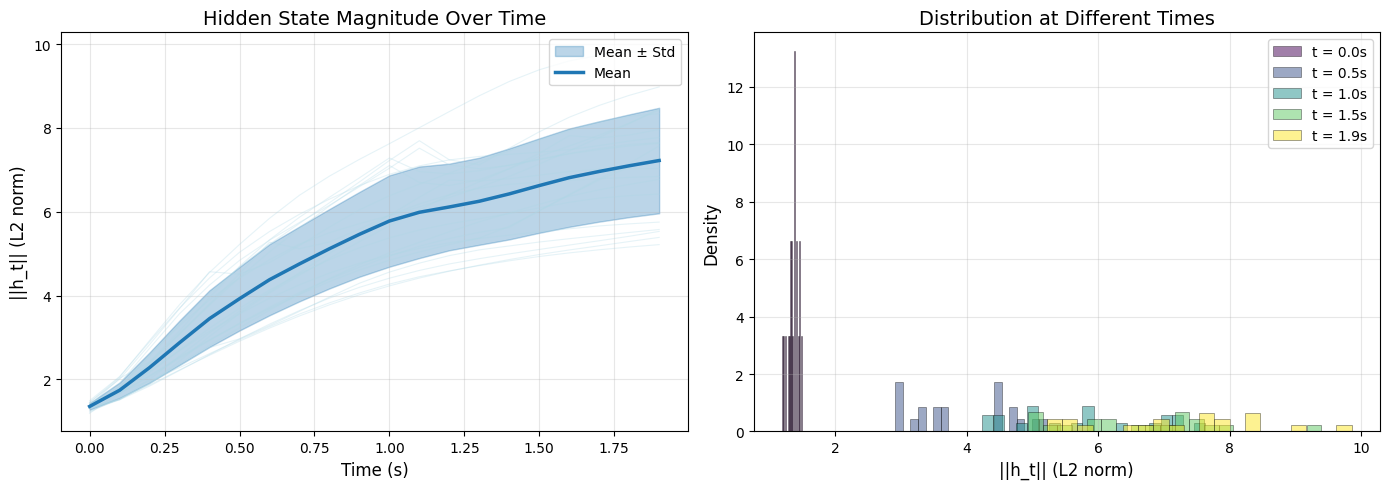


Summary:
  Initial magnitude: 1.3523 ± 0.0784
  Final magnitude:   7.2226 ± 1.2592
  Ratio (final/initial): 5.3408


In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual trajectories + mean
ax1 = axes[0]
for i in range(min(50, hidden_norms.shape[0])):
    ax1.plot(time, hidden_norms[i], color="lightblue", alpha=0.3, linewidth=0.8)

mean_norm = hidden_norms.mean(axis=0)
std_norm = hidden_norms.std(axis=0)
ax1.fill_between(
    time, mean_norm - std_norm, mean_norm + std_norm, alpha=0.3, color="tab:blue", label="Mean ± Std"
)
ax1.plot(time, mean_norm, color="tab:blue", linewidth=2.5, label="Mean")

ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax1.set_title("Hidden State Magnitude Over Time", fontsize=14)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Right: Distribution at different time points
ax2 = axes[1]
time_indices = [
    0,
    num_timesteps // 4,
    num_timesteps // 2,
    3 * num_timesteps // 4,
    num_timesteps - 1,
]
colors = plt.cm.viridis(np.linspace(0, 1, len(time_indices)))

for idx, t_idx in enumerate(time_indices):
    ax2.hist(
        hidden_norms[:, t_idx],
        bins=20,
        alpha=0.5,
        color=colors[idx],
        label=f"t = {time[t_idx]:.1f}s",
        density=True,
        edgecolor="black",
        linewidth=0.5,
    )

ax2.set_xlabel("||h_t|| (L2 norm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Distribution at Different Times", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nSummary:")
print(f"  Initial magnitude: {mean_norm[0]:.4f} ± {std_norm[0]:.4f}")
print(f"  Final magnitude:   {mean_norm[-1]:.4f} ± {std_norm[-1]:.4f}")
print(f"  Ratio (final/initial): {mean_norm[-1] / mean_norm[0]:.4f}")

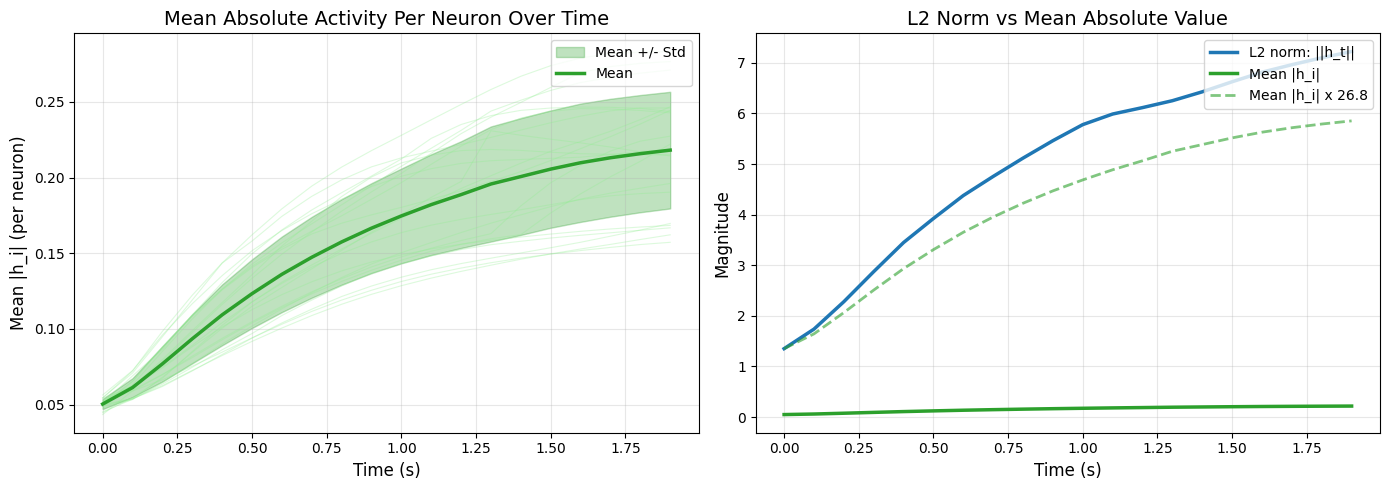


Mean Absolute Activity:
  Initial: 0.0504 +/- 0.0034
  Final:   0.2182 +/- 0.0385
  Ratio (final/initial): 4.3273


In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean absolute value over time
ax1 = axes[0]
for i in range(min(50, hidden_mean_abs.shape[0])):
    ax1.plot(time, hidden_mean_abs[i], color="lightgreen", alpha=0.3, linewidth=0.8)

mean_abs_mean = hidden_mean_abs.mean(axis=0)
mean_abs_std = hidden_mean_abs.std(axis=0)
ax1.fill_between(
    time, mean_abs_mean - mean_abs_std, mean_abs_mean + mean_abs_std,
    alpha=0.3, color="tab:green", label="Mean +/- Std"
)
ax1.plot(time, mean_abs_mean, color="tab:green", linewidth=2.5, label="Mean")

ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Mean |h_i| (per neuron)", fontsize=12)
ax1.set_title("Mean Absolute Activity Per Neuron Over Time", fontsize=14)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Right: Comparison of L2 norm vs mean absolute value
ax2 = axes[1]
ax2.plot(time, mean_norm, color="tab:blue", linewidth=2.5, label="L2 norm: ||h_t||")
ax2.plot(time, mean_abs_mean, color="tab:green", linewidth=2.5, label="Mean |h_i|")

# Add scaled version to compare shapes
scale_factor = mean_norm[0] / mean_abs_mean[0]
ax2.plot(time, mean_abs_mean * scale_factor, color="tab:green", linewidth=2,
         linestyle="--", alpha=0.6, label=f"Mean |h_i| x {scale_factor:.1f}")

ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylabel("Magnitude", fontsize=12)
ax2.set_title("L2 Norm vs Mean Absolute Value", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nMean Absolute Activity:")
print(f"  Initial: {mean_abs_mean[0]:.4f} +/- {mean_abs_std[0]:.4f}")
print(f"  Final:   {mean_abs_mean[-1]:.4f} +/- {mean_abs_std[-1]:.4f}")
print(f"  Ratio (final/initial): {mean_abs_mean[-1] / mean_abs_mean[0]:.4f}")


## Mean Absolute Activity Per Neuron

Instead of L2 norm, we compute the mean absolute value across neurons: `mean(|h_i|)`

This shows the "typical" magnitude of individual neurons rather than the overall vector magnitude.


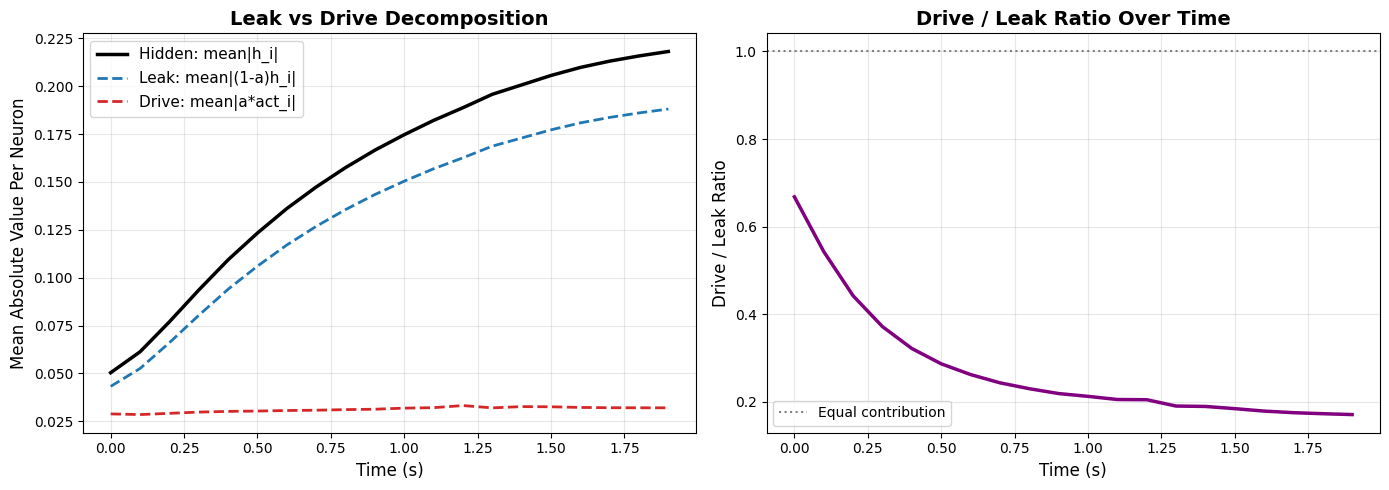


Leak vs Drive (Mean Absolute):
  Initial - Leak: 0.0433, Drive: 0.0289, Ratio: 0.6679
  Final   - Leak: 0.1881, Drive: 0.0321, Ratio: 0.1705


In [66]:
# Decomposition using mean absolute values
mean_hidden_abs = hidden_mean_abs.mean(axis=0)
mean_leak_abs = leak_mean_abs.mean(axis=0)
mean_drive_abs = drive_mean_abs.mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Decomposition
ax = axes[0]
ax.plot(time, mean_hidden_abs, color="black", linewidth=2.5, label="Hidden: mean|h_i|")
ax.plot(time, mean_leak_abs, color="tab:blue", linewidth=2, linestyle="--", label="Leak: mean|(1-a)h_i|")
ax.plot(time, mean_drive_abs, color="tab:red", linewidth=2, linestyle="--", label="Drive: mean|a*act_i|")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Mean Absolute Value Per Neuron", fontsize=12)
ax.set_title("Leak vs Drive Decomposition", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)

# Right: Drive/Leak Ratio
ax = axes[1]
ratio_abs = mean_drive_abs / (mean_leak_abs + 1e-8)
ax.plot(time, ratio_abs, color="purple", linewidth=2.5)
ax.axhline(1.0, color="gray", linestyle=":", linewidth=1.5, label="Equal contribution")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Drive / Leak Ratio", fontsize=12)
ax.set_title("Drive / Leak Ratio Over Time", fontsize=14, fontweight="bold")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nLeak vs Drive (Mean Absolute):")
print(f"  Initial - Leak: {mean_leak_abs[0]:.4f}, Drive: {mean_drive_abs[0]:.4f}, Ratio: {ratio_abs[0]:.4f}")
print(f"  Final   - Leak: {mean_leak_abs[-1]:.4f}, Drive: {mean_drive_abs[-1]:.4f}, Ratio: {ratio_abs[-1]:.4f}")

## Decomposition: Leak vs Drive

Compare the magnitudes of:
- **Leak term**: `(1-α) * h_t` - pulls state toward zero (memory retention)
- **Drive term**: `α * activation(...)` - pushes state based on input and recurrence


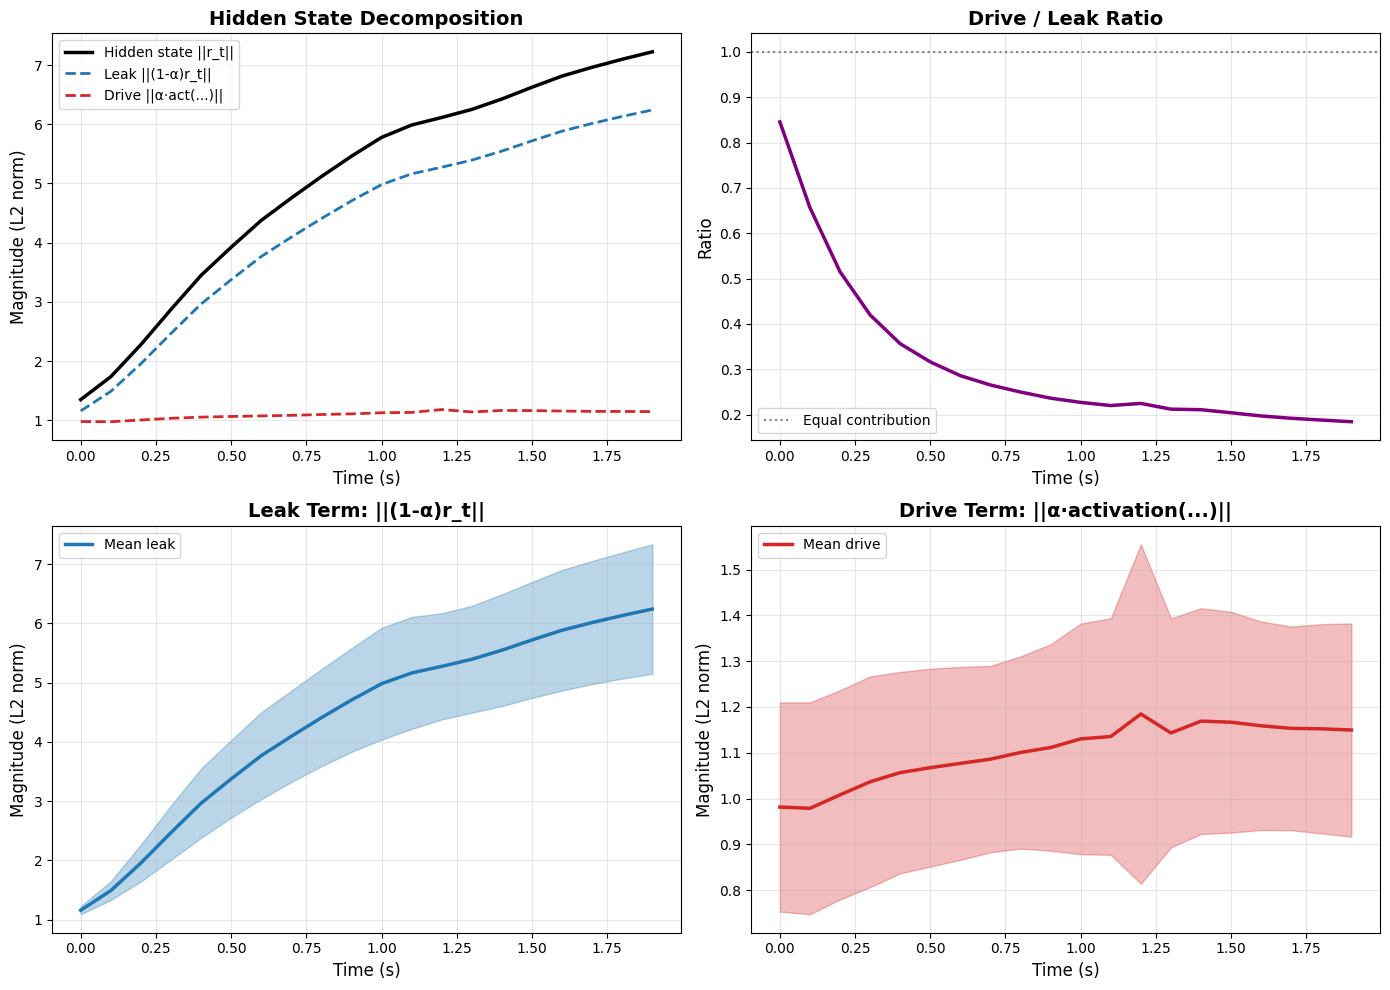


Leak vs Drive Analysis:
  Initial - Leak: 1.1606, Drive: 0.9813, Ratio: 0.8456
  Final   - Leak: 6.2411, Drive: 1.1496, Ratio: 0.1842


In [ ]:
# Compute mean magnitudes
mean_hidden = hidden_norms.mean(axis=0)
mean_leak = leak_norms.mean(axis=0)
mean_drive = drive_norms.mean(axis=0)

std_hidden = hidden_norms.std(axis=0)
std_leak = leak_norms.std(axis=0)
std_drive = drive_norms.std(axis=0)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: All three components
ax = axes[0, 0]
ax.plot(time, mean_hidden, color="black", linewidth=2.5, label="Hidden state ||r_t||", linestyle="-")
ax.plot(time, mean_leak, color="tab:blue", linewidth=2, label="Leak ||(1-α)r_t||", linestyle="--")
ax.plot(time, mean_drive, color="tab:red", linewidth=2, label="Drive ||α·act(...)||", linestyle="--")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Magnitude (L2 norm)", fontsize=12)
ax.set_title("Hidden State Decomposition", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)

# Top right: Ratio of drive to leak
ax = axes[0, 1]
ratio = mean_drive / (mean_leak + 1e-8)
ax.plot(time, ratio, color="purple", linewidth=2.5)
ax.axhline(1.0, color="gray", linestyle=":", linewidth=1.5, label="Equal contribution")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Ratio", fontsize=12)
ax.set_title("Drive / Leak Ratio", fontsize=14, fontweight="bold")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)

# Bottom left: Leak with std
ax = axes[1, 0]
ax.fill_between(time, mean_leak - std_leak, mean_leak + std_leak, alpha=0.3, color="tab:blue")
ax.plot(time, mean_leak, color="tab:blue", linewidth=2.5, label="Mean leak")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Magnitude (L2 norm)", fontsize=12)
ax.set_title("Leak Term: ||(1-α)r_t||", fontsize=14, fontweight="bold")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

# Bottom right: Drive with std
ax = axes[1, 1]
ax.fill_between(time, mean_drive - std_drive, mean_drive + std_drive, alpha=0.3, color="tab:red")
ax.plot(time, mean_drive, color="tab:red", linewidth=2.5, label="Mean drive")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Magnitude (L2 norm)", fontsize=12)
ax.set_title("Drive Term: ||α·activation(...)||", fontsize=14, fontweight="bold")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nLeak vs Drive Analysis:")
print(f"  Initial - Leak: {mean_leak[0]:.4f}, Drive: {mean_drive[0]:.4f}, Ratio: {ratio[0]:.4f}")
print(f"  Final   - Leak: {mean_leak[-1]:.4f}, Drive: {mean_drive[-1]:.4f}, Ratio: {ratio[-1]:.4f}")

---

# ReLU vs Tanh Activation Comparison

Compare hidden state dynamics between models trained with different activation functions.


In [84]:
# Experiment directory
experiment_dir = Path("/home/facosta/timescales/timescales/logs/experiments/activation_comparison_20260109_000444")


# Model directories
relu_dir = experiment_dir / "activation_ReLU" / "seed_0"
tanh_dir = experiment_dir / "activation_Tanh" / "seed_0"

print(f"ReLU model: {relu_dir.exists()}")
print(f"Tanh model: {tanh_dir.exists()}")

ReLU model: True
Tanh model: True


In [ ]:
def load_model(model_dir):
    """Load a model from directory."""
    with open(model_dir / "config_seed0.yaml") as f:
        config = yaml.safe_load(f)
    
    activation_fn = getattr(torch.nn, config["activation"])
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=config.get("timescales_config"),
        activation=activation_fn,
        learn_timescales=config.get("learn_timescales", False),
    )
    model.load_state_dict(
        torch.load(model_dir / "final_model_seed0.pth", map_location="cpu", weights_only=True)
    )
    model.eval()
    
    place_cell_centers = torch.load(model_dir / "place_cell_centers_seed0.pt", weights_only=True)
    
    return model, config, place_cell_centers


# Load both models
relu_model, relu_config, relu_pcc = load_model(relu_dir)
tanh_model, tanh_config, tanh_pcc = load_model(tanh_dir)

print(f"ReLU model activation: {relu_model.rnn_step.activation}")
print(f"Tanh model activation: {tanh_model.rnn_step.activation}")

Timescales are LEARNABLE (randomly initialized)
Timescales are LEARNABLE (randomly initialized)
ReLU model activation: ReLU()
Tanh model activation: Tanh()


In [92]:
# Generate trajectories (use ReLU config, they should be identical)
num_time_steps_eval = 100

datamodule_cmp = PathIntegrationDataModule(
    trajectory_type=relu_config["trajectory_type"],
    velocity_representation=relu_config["velocity_representation"],
    dt=relu_config["dt"],
    num_time_steps=num_time_steps_eval,
    arena_size=relu_config["arena_size"],
    num_place_cells=relu_config["num_place_cells"],
    place_cell_rf=relu_config["place_cell_rf"],
    DoG=relu_config["DoG"],
    surround_scale=relu_config["surround_scale"],
    place_cell_layout=relu_config["place_cell_layout"],
    behavioral_timescale_mean=relu_config.get("behavioral_timescale_mean", 1.0),
    behavioral_timescale_std=relu_config.get("behavioral_timescale_std", 0.2),
    linear_speed_tau=relu_config.get("linear_speed_tau", 1.0),
    angular_speed_mean=relu_config.get("angular_speed_mean", 0.0),
    angular_speed_std=relu_config.get("angular_speed_std", 1.0),
    angular_speed_tau=relu_config.get("angular_speed_tau", 0.4),
    num_trajectories=100,
    batch_size=100,
    num_workers=10,
    train_val_split=0.0,
)
datamodule_cmp.place_cell_centers = relu_pcc
datamodule_cmp.setup()

batch_cmp = next(iter(datamodule_cmp.val_dataloader()))
inputs_cmp, positions_cmp, place_cells_cmp = batch_cmp

print(f"Test trajectories: {inputs_cmp.shape}")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Test trajectories: torch.Size([100, 100, 2])


In [87]:
# Run both models
relu_init = relu_model.W_h_init(place_cells_cmp[:, 0, :])
tanh_init = tanh_model.W_h_init(place_cells_cmp[:, 0, :])

relu_hidden, relu_leak, relu_drive = compute_dynamics_decomposition(relu_model, inputs_cmp, relu_init)
tanh_hidden, tanh_leak, tanh_drive = compute_dynamics_decomposition(tanh_model, inputs_cmp, tanh_init)

# Compute norms
relu_norms = torch.norm(relu_hidden, dim=2).numpy()
tanh_norms = torch.norm(tanh_hidden, dim=2).numpy()

relu_mean_abs = torch.abs(relu_hidden).mean(dim=2).numpy()
tanh_mean_abs = torch.abs(tanh_hidden).mean(dim=2).numpy()

# Time axis
time_cmp = np.arange(num_time_steps_eval) * relu_config["dt"]

print(f"ReLU hidden norms shape: {relu_norms.shape}")
print(f"Tanh hidden norms shape: {tanh_norms.shape}")

ReLU hidden norms shape: (100, 1000)
Tanh hidden norms shape: (100, 1000)


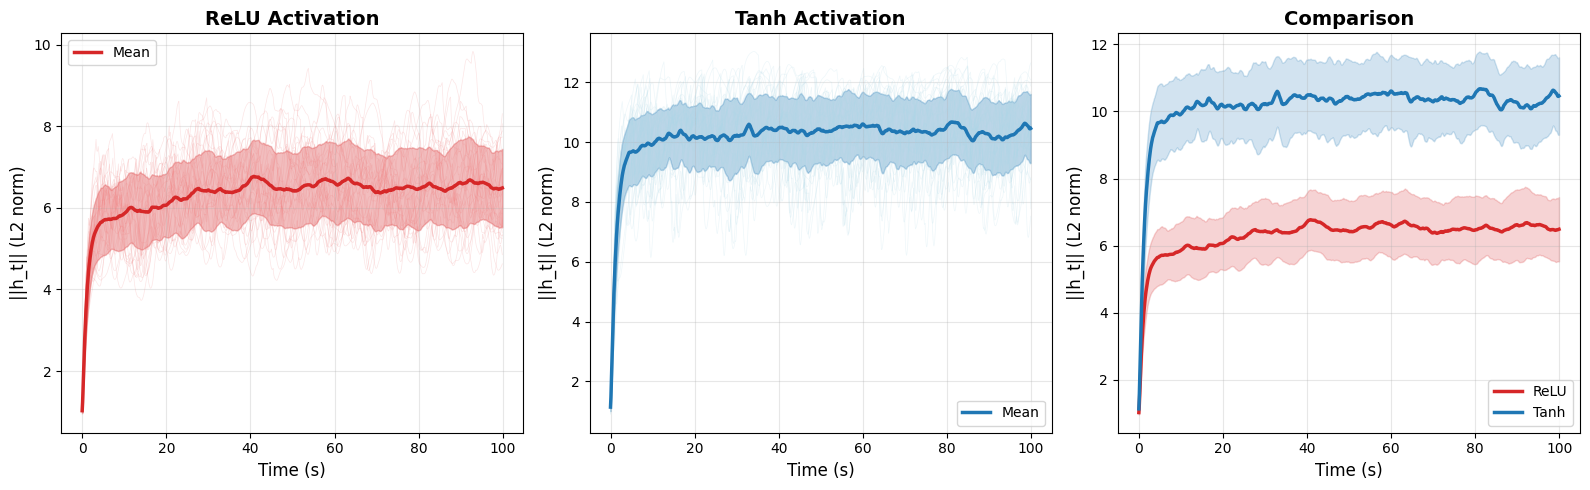


L2 Norm Summary:
  ReLU - Initial: 1.03, Final: 6.49, Ratio: 6.31x
  Tanh - Initial: 1.14, Final: 10.46, Ratio: 9.20x


In [88]:
# Side-by-side comparison: L2 norm
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: ReLU
ax = axes[0]
relu_mean = relu_norms.mean(axis=0)
relu_std = relu_norms.std(axis=0)
for i in range(min(30, relu_norms.shape[0])):
    ax.plot(time_cmp, relu_norms[i], color="lightcoral", alpha=0.2, linewidth=0.5)
ax.fill_between(time_cmp, relu_mean - relu_std, relu_mean + relu_std, alpha=0.3, color="tab:red")
ax.plot(time_cmp, relu_mean, color="tab:red", linewidth=2.5, label="Mean")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax.set_title("ReLU Activation", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# Middle: Tanh
ax = axes[1]
tanh_mean = tanh_norms.mean(axis=0)
tanh_std = tanh_norms.std(axis=0)
for i in range(min(30, tanh_norms.shape[0])):
    ax.plot(time_cmp, tanh_norms[i], color="lightblue", alpha=0.2, linewidth=0.5)
ax.fill_between(time_cmp, tanh_mean - tanh_std, tanh_mean + tanh_std, alpha=0.3, color="tab:blue")
ax.plot(time_cmp, tanh_mean, color="tab:blue", linewidth=2.5, label="Mean")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax.set_title("Tanh Activation", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Overlay comparison
ax = axes[2]
ax.fill_between(time_cmp, relu_mean - relu_std, relu_mean + relu_std, alpha=0.2, color="tab:red")
ax.fill_between(time_cmp, tanh_mean - tanh_std, tanh_mean + tanh_std, alpha=0.2, color="tab:blue")
ax.plot(time_cmp, relu_mean, color="tab:red", linewidth=2.5, label="ReLU")
ax.plot(time_cmp, tanh_mean, color="tab:blue", linewidth=2.5, label="Tanh")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax.set_title("Comparison", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nL2 Norm Summary:")
print(f"  ReLU - Initial: {relu_mean[0]:.2f}, Final: {relu_mean[-1]:.2f}, Ratio: {relu_mean[-1]/relu_mean[0]:.2f}x")
print(f"  Tanh - Initial: {tanh_mean[0]:.2f}, Final: {tanh_mean[-1]:.2f}, Ratio: {tanh_mean[-1]/tanh_mean[0]:.2f}x")

In [ ]:
relu_model

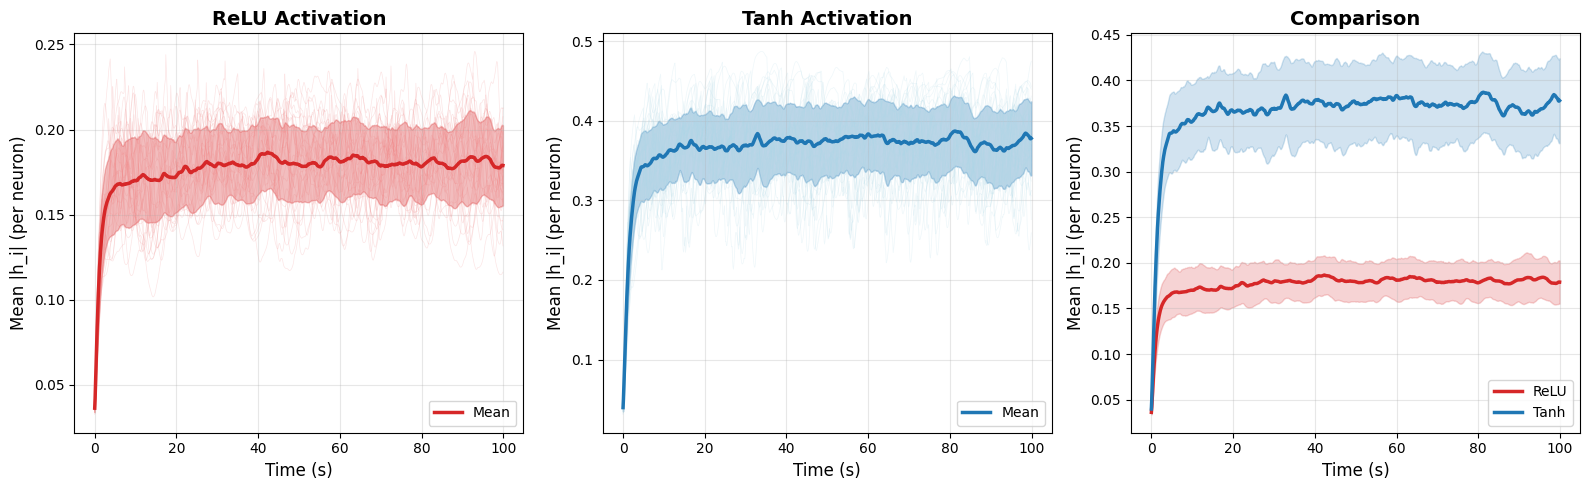


Mean Absolute Value Summary:
  ReLU - Initial: 0.0361, Final: 0.1789, Ratio: 4.95x
  Tanh - Initial: 0.0398, Final: 0.3778, Ratio: 9.50x


In [89]:
# Side-by-side comparison: Mean absolute value per neuron
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: ReLU
ax = axes[0]
relu_abs_mean = relu_mean_abs.mean(axis=0)
relu_abs_std = relu_mean_abs.std(axis=0)
for i in range(min(30, relu_mean_abs.shape[0])):
    ax.plot(time_cmp, relu_mean_abs[i], color="lightcoral", alpha=0.2, linewidth=0.5)
ax.fill_between(time_cmp, relu_abs_mean - relu_abs_std, relu_abs_mean + relu_abs_std, alpha=0.3, color="tab:red")
ax.plot(time_cmp, relu_abs_mean, color="tab:red", linewidth=2.5, label="Mean")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Mean |h_i| (per neuron)", fontsize=12)
ax.set_title("ReLU Activation", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# Middle: Tanh
ax = axes[1]
tanh_abs_mean = tanh_mean_abs.mean(axis=0)
tanh_abs_std = tanh_mean_abs.std(axis=0)
for i in range(min(30, tanh_mean_abs.shape[0])):
    ax.plot(time_cmp, tanh_mean_abs[i], color="lightblue", alpha=0.2, linewidth=0.5)
ax.fill_between(time_cmp, tanh_abs_mean - tanh_abs_std, tanh_abs_mean + tanh_abs_std, alpha=0.3, color="tab:blue")
ax.plot(time_cmp, tanh_abs_mean, color="tab:blue", linewidth=2.5, label="Mean")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Mean |h_i| (per neuron)", fontsize=12)
ax.set_title("Tanh Activation", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Overlay comparison
ax = axes[2]
ax.fill_between(time_cmp, relu_abs_mean - relu_abs_std, relu_abs_mean + relu_abs_std, alpha=0.2, color="tab:red")
ax.fill_between(time_cmp, tanh_abs_mean - tanh_abs_std, tanh_abs_mean + tanh_abs_std, alpha=0.2, color="tab:blue")
ax.plot(time_cmp, relu_abs_mean, color="tab:red", linewidth=2.5, label="ReLU")
ax.plot(time_cmp, tanh_abs_mean, color="tab:blue", linewidth=2.5, label="Tanh")
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Mean |h_i| (per neuron)", fontsize=12)
ax.set_title("Comparison", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nMean Absolute Value Summary:")
print(f"  ReLU - Initial: {relu_abs_mean[0]:.4f}, Final: {relu_abs_mean[-1]:.4f}, Ratio: {relu_abs_mean[-1]/relu_abs_mean[0]:.2f}x")
print(f"  Tanh - Initial: {tanh_abs_mean[0]:.4f}, Final: {tanh_abs_mean[-1]:.4f}, Ratio: {tanh_abs_mean[-1]/tanh_abs_mean[0]:.2f}x")

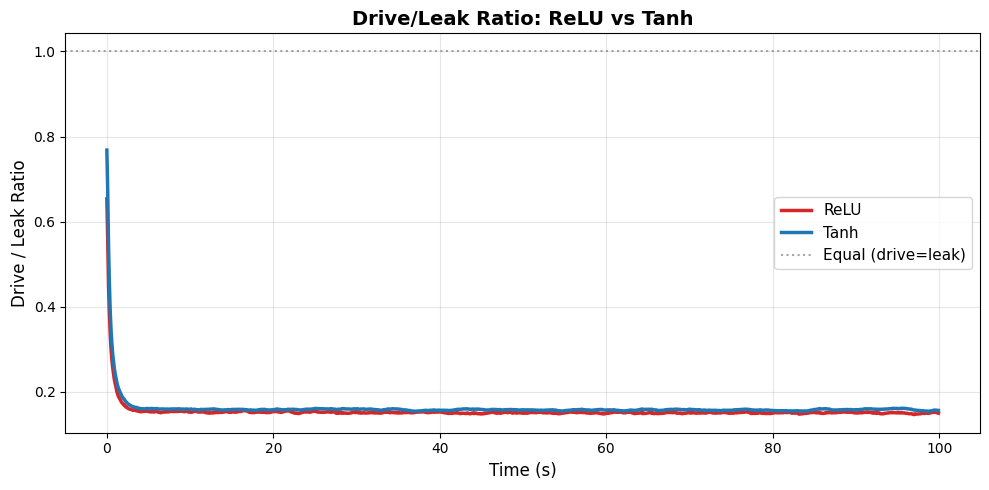


Drive/Leak Ratio:
  ReLU - Initial: 0.653, Final: 0.149
  Tanh - Initial: 0.768, Final: 0.156


In [90]:
# Drive/Leak ratio comparison
relu_leak_norms = torch.norm(relu_leak, dim=2).numpy()
relu_drive_norms = torch.norm(relu_drive, dim=2).numpy()
tanh_leak_norms = torch.norm(tanh_leak, dim=2).numpy()
tanh_drive_norms = torch.norm(tanh_drive, dim=2).numpy()

relu_ratio = relu_drive_norms.mean(axis=0) / (relu_leak_norms.mean(axis=0) + 1e-8)
tanh_ratio = tanh_drive_norms.mean(axis=0) / (tanh_leak_norms.mean(axis=0) + 1e-8)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(time_cmp, relu_ratio, color="tab:red", linewidth=2.5, label="ReLU")
ax.plot(time_cmp, tanh_ratio, color="tab:blue", linewidth=2.5, label="Tanh")
ax.axhline(1.0, color="gray", linestyle=":", linewidth=1.5, alpha=0.7, label="Equal (drive=leak)")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Drive / Leak Ratio", fontsize=12)
ax.set_title("Drive/Leak Ratio: ReLU vs Tanh", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDrive/Leak Ratio:")
print(f"  ReLU - Initial: {relu_ratio[0]:.3f}, Final: {relu_ratio[-1]:.3f}")
print(f"  Tanh - Initial: {tanh_ratio[0]:.3f}, Final: {tanh_ratio[-1]:.3f}")

/home/facosta/.cache/pypoetry/virtualenvs/pirnns-yK7ughNc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


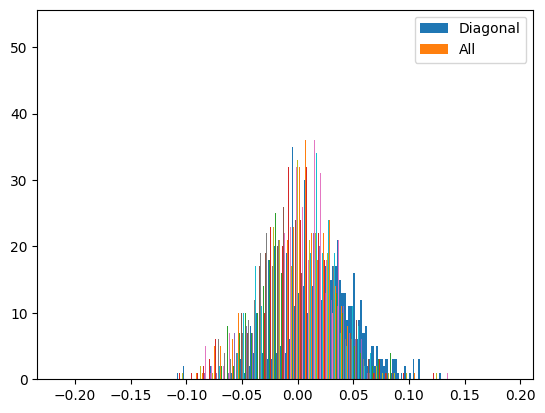

In [91]:
# get diagonal of W_rec

relu_weights = relu_model.rnn_step.W_rec.weight.detach().numpy()
tanh_weights = tanh_model.rnn_step.W_rec.weight.detach().numpy()

plt.hist(relu_weights.diagonal(),bins=100,label="Diagonal")
plt.hist(relu_weights,bins=100,label="All")
plt.legend()
plt.show()

plt.show()